# Example: NN and ICNNS in larger optimization problems

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [1]:
using Flux
using Random
using Gogeta
using Plots
using Gurobi
using JuMP
using JSON

## Formulation of Neural Networks (NNs)

In some of the previous examples, related to the neural networks, we mentioned that we can add some additional constraints to the  formulation of the NN. In those examples, after formulation of the NN, we were manually extracting the needed input variables from the formulation and adding needed constraints. But in this Jupyter notebook, we are going to present a more efficient way how to use NN in larger optimization models.

### Define known variables and constraints

Let input variables are $x\in [-1.5, -0.5]$ and $y\in[-0.5,0.5]$. 

We also know that $y\geq -x-1$. 


At first, create `JuMP` model

In [2]:
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


Add variables and constraints of interest to `JuMP` model

In [3]:
@variable(jump_model, -1.5 <= x <= -0.5);
@variable(jump_model, -0.5 <= y <= 0.5);
@constraint(jump_model, y >= -x - 1);

Now we also know that there exists some arbitrary function $$z = f(x,y)$$
that can not be represented explicitly, but only with a surrogate model using NN. And we want to incorporate this dependency into our `JuMP` model. Ar first, we add it as some variavle `z`, but keep in mind that it will be associated with a neural network input.

In [4]:
@variable(jump_model, z);

### Innitialize Neural Network 

In [5]:
# Create a small neural network with random weights
begin
    Random.seed!(1234);

    NN_model = Chain(
        Dense(2 => 10, relu),
        Dense(10 => 50, relu),
        Dense(50 => 20, relu),
        Dense(20 => 5, relu),
        Dense(5 => 1)
    )
end

# Set upper and lower input bounds
init_U = [-0.5, 0.5];
init_L = [-1.5, -0.5];

This plot shows how the mixed integer problem should look like

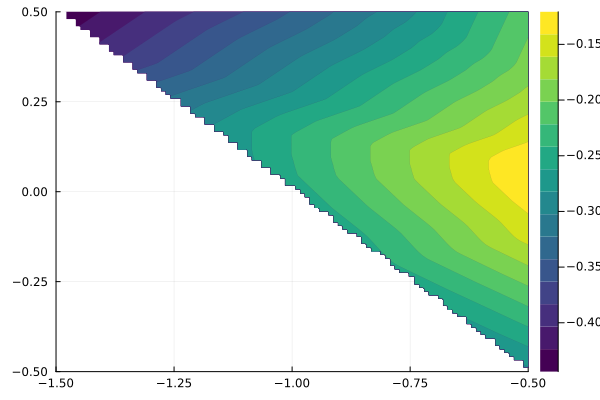

In [7]:
# contour plot the model in the feasible region of the following optimization problem
x_range = LinRange{Float32}(init_L[1], init_U[1], 100);
y_range = LinRange{Float32}(init_L[2], init_U[2], 100);

contourf(x_range, y_range, (x, y) -> if y >= -x-1 NN_model(hcat(x, y)')[] else NaN end, c=cgrad(:viridis), lw=0)


### Chose objective function, formulate model and optimize

The objective function can be anything you want. Suppose, you want to find $$\text{max } f(x,y) - 0.5x$$

In [9]:
@objective(jump_model, Max, z - 0.5*x);

***Note:*** Don't forget to set up `set_solver()` function. This is example how it can be done with `Gurobi`:

In [10]:
function set_solver!(jump)
    set_optimizer(jump, () -> Gurobi.Optimizer())
    set_silent(jump)
end

set_solver! (generic function with 1 method)

Finally, neural network can be incorporated into the `JuMP` model using function `NN_incorporate!()`, which has following set of input parameters:

***Arguments***
- `jump_original`: JuMP model into which the neural network MIP should be incorporated
- `param_source`: relative path to the JSON file containing the model parameters OR a Flux.Chain model
- `output_var`: reference to the variable that should be linked to the NN output
- `input_vars`: references to the variables that will be used as the NN inputs

***Keyword Arguments***

- `U_in`: vector of upper bounds for the input variables
- `L_in`: vector of lower bounds for the input variables
- `compress`: reduce NN size by removing stable and linearly dependent neurons
- `bound_tightening`: which bound tightening mode to use: "fast", "standard", "output"
- `parallel`: use multiprocessing for bound tightening
- `silent`: suppress console output
- `U_out`: vector of upper bounds for the output variables - necessary when output bound tightening is used
- `L_out`: vector of lower bounds for the output variables - necessary when output bound tightening is used

In [11]:
# always put first variable associated with NN output, and then input variables 
# should be provided in the same order as they were provided while training of NN

NN_incorporate!(jump_model, NN_model, z, x, y; U_in=init_U, L_in=init_L, bound_tightening="standard", silent=true)

IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting)))

The `jump_model` now is formulated and can be optimized

In [12]:
jump_model

A JuMP Model
Maximization problem with:
Variables: 261
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 89 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 171 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 170 constraints
`AffExpr`-in-`MathOptInterface.Interval{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 85 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, y, z

The model found next solution:

In [13]:
optimize!(jump_model)
x_opt = value(x)
y_opt = value(y)

println("Solution:")
println("x = ", x_opt)
println("y = " , y_opt)

Solution:
x = -1.2609439405453131
y = 0.2609439405453131


In [14]:
solution_summary(jump_model)

* Solver : Gurobi

* Status
  Result count       : 3
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 3.09040e-01
  Objective bound    : 3.09066e-01
  Relative gap       : 8.35390e-05
  Dual objective value : 3.09066e-01

* Work counters
  Solve time (sec)   : 3.76959e-02
  Barrier iterations : 0
  Node count         : 1


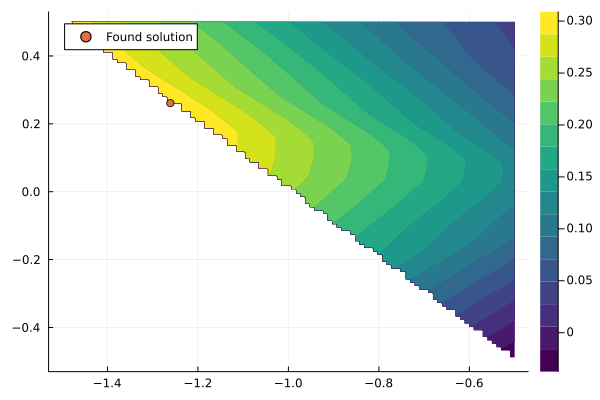

In [16]:
contourf(x_range, y_range, (x_in, y_in) -> if y_in >= -x_in-1 forward_pass_NN!(jump_model, [x_in, y_in], z, x, y) - 0.5 *x_in else NaN end, c=cgrad(:viridis), lw=0)
scatter!([x_opt], [y_opt], label="Found solution")

The output of this surogate model can be found using function `forward_pass_NN!()`. It has following set of input parameters:

- `jump`: JuMP model with the NN formulation
- `input`: value to be forward passed
- `output_var`: reference to the NN output variable
- `input_vars`: references to the NN input variables


In [18]:
forward_pass_NN!(jump_model, [-1, 0.2], z, x, y)

-0.2529951398078906

The function is not defined at this point, so we are expecting to see warning

In [20]:
forward_pass_NN!(jump_model, [-1, -0.5], z, x, y)

Error with forward pass: MathOptInterface.ResultIndexBoundsError{MathOptInterface.VariablePrimal}(MathOptInterface.VariablePrimal(1), 0)


┌ Warning: Input or output outside of bounds or incorrectly constructed model.
└ @ Main In[6]:288


NaN

For self check, we can calculate the values produced by neural network and formulation to see if they are the same.

In [22]:
# check that NN formulation matches Flux model
set_silent(jump_model)
check = [if y_in >= -x_in - 1 forward_pass_NN!(jump_model, [x_in, y_in], z, x, y) ≈ NN_model(hcat(x_in, y_in)')[] end for x_in in x_range, y_in in y_range]
println("Are they the same? ", all(value -> value === nothing || value == true, check))

Are they the same? true


### Summary: Formulation of NN in larger optimization problems

The formulation can be summarized as follows:

In [24]:
# STEP 1: innitialize jump model
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)

# STEP 2a: add variable that will store output of NN
@variable(jump_model, z);

# STEP 2b: add variables that are associated with input variables of NN
@variable(jump_model, x);
@variable(jump_model, y);

# STEP 3: add constraints of interest
@constraint(jump_model, y >= -x - 1);

# STEP 4: set objective function
@objective(jump_model, Max, z - 0.5*x);

# STEP 5: incorporate NN to jump model
NN_incorporate!(jump_model, NN_model, z, x, y; U_in=init_U, L_in=init_L, bound_tightening="standard", silent=true)

# STEP 6: Optimize model and extract the found optimum solutions
optimize!(jump_model)
x_opt = value(x);
y_opt = value(y);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


## Formulation of Input Convex Neural Networks (ICNNs) 

In input convex neural networks, the neuron weights are constrained to be nonnegative and weighted skip connections are added from the input layer to each layer.  More details can be found in [Amos et al. (2017)](https://gamma-opt.github.io/Gogeta.jl/stable/literature/). The properties of the ICNNs allow it to be formulated as linear programming problem (LP) which is much more computationally efficient than formulating regular NNs.

The problem is that as far as we know, there is no functionality in `Flux` package to create ICNNs. Instead we created it using `TensorFlow` package in python (see the code in [model/icnn_training.ipynb](https://github.com/gamma-opt/Gogeta.jl/tree/main/examples/neural_networks/model/icnn_training.ipynb)).  And exported the ICNNs as a .json file (mode details about requirements for .json file format can be found in the [documentation](https://gamma-opt.github.io/Gogeta.jl/stable/reference/#Gogeta.ICNN_incorporate!-Tuple{JuMP.Model,%20String,%20Any,%20Vararg{Any}})).

### Adding existing variables and constraints

For simplicity, we will use the same variables and constraints as in NNs example, but this time surrogate model $$z = f(x,y)$$
is represented as ICNN model

In [58]:
jump_model = Model(Gurobi.Optimizer);
set_silent(jump_model)

@variable(jump_model, -1 <= x <= 1);
@variable(jump_model, -1 <= y <= 1);

#variable associated with ICNNs output
@variable(jump_model, z);

@constraint(jump_model, y >= 1-x);
@objective(jump_model, Min, x+y);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


## Incorporate ICNN model to optimization problem

To incorporate ICNN model into `JuMP` model, we need to call function `ICNN_incorporate!()`. It has following set of input parameters:
- `jump`: JuMP model where the LP formulation should be incorporated
- `filepath`: relative path to the JSON file containing the model parameters
- `output_var`: reference to the variable that should be linked to the ICNN output
- `input_vars`: references to the variables that will be used as the ICNN inputs


In [59]:
filepath = "model/model_weights.json"
ICNN_incorporate!(jump_model, filepath, z, x, y);

In [60]:
# see optimal solution
optimize!(jump_model)
x_opt = value(x)
y_opt = value(y)

println("Solution:")
println("x = ", x_opt)
println("y = " , y_opt)

Solution:
x = 0.432431565441616
y = 0.567568434558384


In [61]:
solution_summary(jump_model)

* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 1.59934e+00
  Objective bound    : 1.59934e+00
  Dual objective value : 1.59934e+00

* Work counters
  Solve time (sec)   : 1.25694e-03
  Barrier iterations : 0
  Node count         : 0


### Plot ICNN

Now, we can plot ICNN if we drop the constraint
$$y\geq 1-x$$

In [62]:
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)

@variable(jump_model, -1 <= x <= 1)
@variable(jump_model, -1 <= y <= 1)
@variable(jump_model, z)
@objective(jump_model, Min, 1)

ICNN_incorporate!(jump_model, "model/model_weights.json", z, x, y);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


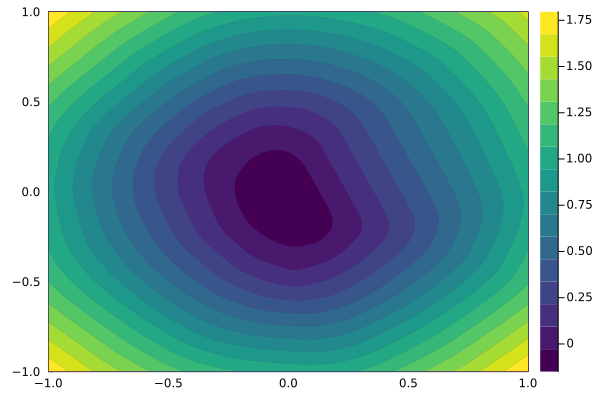

In [63]:
x_range = LinRange{Float32}(-1, 1, 100);
y_range = LinRange{Float32}(-1, 1, 100);

contourf(x_range, y_range, (x_in, y_in) -> forward_pass_ICNN!(jump_model, [x_in, y_in], z, x, y), c=cgrad(:viridis), lw=0)